In [3]:
import pandas as pd
import numpy as np

### XGBoost

In [57]:
class XGBoost:
    def __init__(self, 
                 base_score = 0.5,
                 max_depth = 3,
                 M = 10,
                 lambd = 1,
                 gamma = 0,
                 min_sample = 1):
        
        self.base_score = base_score  # 最开始时给叶子节点权重所赋的值
        self.max_depth = max_depth  # 树最大深度
        self.M = M  # 树的个数
        self.lambd = lambd  # L2正则项的参数
        self.gamma = gamma  # 叶子节点数T的参数
        self.min_sample = min_sample # 每个叶子节点的样本数
        self.tree_structure = {} # 用一个字典来存储每一棵树的树结构
        self.plot = True
        

    # 回归树算法
    def _build_tree(self, X, w, depth):
        '''
        递归建树
        w:每个样本的权重
        depth:树的深度
        '''
        
        if depth > self.max_depth: # 达到最大训练棵树直接退出
            return
        
        best_feature, best_f_value = None, None # 初始化特征和最优划分
        
        max_gain = 0 # 记录最大增益
        G_left_best, G_right_best, H_left_best, H_right_best = 0,0,0,0
        
        for feature in [x for x in X.columns if x not in ['g','h','y']]: # 遍历所有特征
            for f_value in list(set(X[feature])): # 遍历对应特征的所有划分点
                
                # 如果分裂后左右样本数目都小于指定值则退出
                if self.min_sample:
                    if (X.loc[X[feature] < f_value].shape[0] < self.min_sample)\
                        |(X.loc[X[feature] >= f_value].shape[0] < self.min_sample):
                        continue
                
                # 计算划分后对应的一阶导和二阶导
                G_left = X.loc[X[feature] < f_value,'g'].sum()
                G_right = X.loc[X[feature] >= f_value,'g'].sum()
                H_left = X.loc[X[feature] < f_value,'h'].sum()
                H_right = X.loc[X[feature] >= f_value,'h'].sum()
               
                # 计算某次分裂带来的增益
                gain = G_left**2/(H_left + self.lambd) + \
                       G_right**2/(H_right + self.lambd) - \
                       (G_left + G_right)**2/(H_left + H_right + self.lambd)
                gain = gain/2 - self.gamma
                if gain > max_gain:
                    best_feature, best_f_value = feature, f_value
                    max_gain = gain
                    G_left_best, G_right_best, H_left_best, H_right_best = G_left, G_right, H_left, H_right

                if best_feature is None:
                    return None
        
        #给每个叶子节点上的样本分别赋上相应的权重值
        id_left = X.loc[X[best_feature] < best_f_value].index.tolist()
        w_left = - G_left_best / (H_left_best + self.lambd)

        id_right = X.loc[X[best_feature] >= best_f_value].index.tolist()
        w_right = - G_right_best / (H_right_best + self.lambd)
        
        w[id_left] = w_left
        w[id_right] = w_right
        
        #用json串把树的结构给存下来
        tree_structure = {(best_feature,best_f_value):{}}
        tree_structure[(best_feature,best_f_value)][('left',w_left)] = self._build_tree(X.loc[id_left], w, depth + 1)
        tree_structure[(best_feature,best_f_value)][('right',w_right)] = self._build_tree(X.loc[id_right], w, depth + 1)
                
        return tree_structure

    
    def _cal_grad(self, y_hat, Y):
        '''
        计算目标函数的一阶导
        '''
        return 2* (y_hat - Y)

    def _cal_hess(self,y_hat, Y):
        '''
        计算目标函数的二阶导
        '''
        return np.array([2]*Y.shape[0])
    
    def fit(self, X, Y):
        '''
        根据训练数据集X和Y训练出树结构和权重
        '''
        X = X.reset_index(drop = 'True')
        Y = Y.values
        error_table = [] # 记录错误
        # 将base_score设为Y的均值
        self.base_score = np.mean(Y)
        y_hat = np.array([self.base_score]*Y.shape[0])
        error = np.sum((y_hat - Y)**2)
        error_table.append(error)
        for t in range(self.M):
            
            X['g'] = self._cal_grad(y_hat, Y)
            X['h'] = self._cal_hess(y_hat, Y)
            
            f_t = pd.Series([0]*Y.shape[0])
            self.tree_structure[t+1] = self._build_tree(X, f_t, 1)

            y_hat = y_hat + f_t # 对预测值更新
            error = np.sum((y_hat - Y)**2)
            error_table.append(error)
        
        if self.plot:
            from matplotlib import pyplot as plt
            plt.title('error ratio of training')
            plt.xlabel('Tree Number')
            plt.ylabel('Error')
            x = list(range(self.M+1))
            plt.plot(x, error_table)
            plt.show()

    def _get_tree_node_w(self, X, tree, w):
        # 把权重赋给w
        if not tree is None:
            k = list(tree.keys())[0]
            feat,f_value = k[0],k[1]
            X_left = X.loc[X[feat] < f_value]
            id_left = X_left.index.tolist()
            X_right = X.loc[X[feat] >= f_value]
            id_right = X_right.index.tolist()
            for kk in tree[k].keys():
                if kk[0] == 'left':
                    tree_left = tree[k][kk]
                    w[id_left] = kk[1]
                elif kk[0] == 'right':
                    tree_right = tree[k][kk]
                    w[id_right] = kk[1]
        
            self._get_tree_node_w(X_left, tree_left, w)
            self._get_tree_node_w(X_right, tree_right, w)

    def predict(self, X):
        X = X.reset_index(drop='True')
        Y = pd.Series([self.base_score]*X.shape[0])

        for t in range(self.M):
            tree = self.tree_structure[t+1]
            y_hat = pd.Series([0]*X.shape[0]) # 初始化
            self._get_tree_node_w(X, tree, y_hat)
            Y = Y + y_hat
            
        return Y

### Load the data

In [52]:
# Load the dataset
import numpy as np
import pandas as pd
from math import *
df = pd.read_table("train.data.txt",sep = ', ',header=None)
# Split train set and test set
# Choosing 75% as train set
row = df.shape[0]
col = df.shape[1]
k = int(0.75*row)
train = df[0:k]
test = df[k:row]
X_train = train.iloc[:,0:col-1]
y_train = train.iloc[:,col-1]
X_test = test.iloc[:,0:col-1]
y_test = test.iloc[:,col-1]

C:\Users\DELL\AppData\Local\Temp\ipykernel_9152\1061405684.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table("train.data.txt",sep = ', ',header=None)


### Train the model

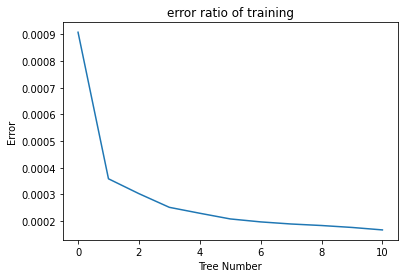

In [65]:
model = XGBoost(M = 10, max_depth = 3, lambd = 1)
model.fit(X_train,y_train)

### Predict

In [66]:
y_pred = model.predict(X_test)
delta = np.array(y_test) - np.array(y_pred)
delta_norm = np.linalg.norm(delta)
RMSE = delta_norm / sqrt(X_test.shape[0])
print("The RMSE is ",RMSE)

The RMSE is  0.0001978310618562626
